In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/online-retail-dataset/online_retail.csv


# Introduction

I am a Data Analyst for a fictitious Online Retail Company and I have been tasked by my supervisors to find and segment customers that have purchased from this Online Retail Company. My task is to categorize customers into groups and give insights and recommendations into which group the company needs to focus on. An additional task would be to provide insights on returning customers.

This dataset contains transactions from an online retail store which includes transaction features such as Quantity, transaction date, price and many more. My objective for this project is to 

1. Conduct a **Cohort Analysis**
2. Apply Customer Segmentation based on **RFM (Recency, Frequency and Monetary Value)**
3. Apply Customer Segmentation through **KMeans**

# Data Cleaning

Before conducting analysis, I will apply a few Data cleaning methods that consist of:

1. **Removing Missing Values**
2. **Converting features to the correct Data type**

In [2]:
#Importing Basic Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
#Importing File

df = pd.read_csv('/kaggle/input/online-retail-dataset/online_retail.csv')

In [4]:
#Checking Overview of the Data

print(df.shape)
print(df.dtypes)
df.head()

(541909, 8)
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<AxesSubplot:>

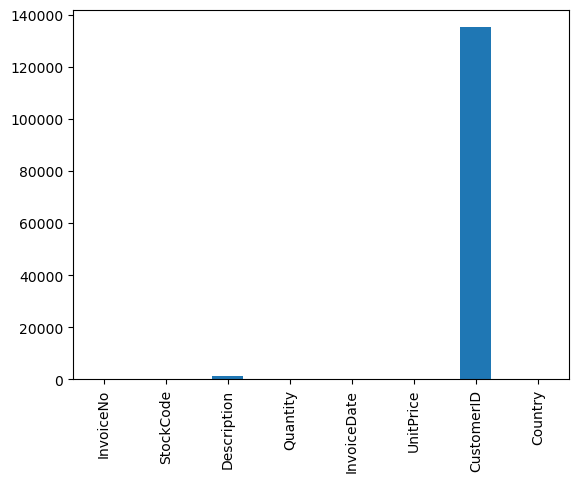

In [5]:
#Checking for Missing Values

df.isna().sum().plot.bar()

Since we have a lot of data to work with, I will drop all missing values in CustomerID. While keeping the missing values in the Description Column since we are not going to be using much of the description column.

In [6]:
#Drop Missing Data on CustomerID

df.dropna(subset=['CustomerID'], inplace=True)

In [7]:
#Converting Invoice Date column to Date Time Data Type

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Cohort Analysis

In [8]:
#Finding the Aquisition Month Cohort

def get_month(n): return dt.datetime(n.year, n.month, 1)

df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
cust_month = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = cust_month.transform('min')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [9]:
#Extracting values from data

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [10]:
#Creating Cohort Index

invoice_year, invoice_month, _ = get_date_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

df['CohortIndex'] = years_diff * 12 + months_diff + 1

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


There is a 1 on the CohortIndex to signify the first month instead of the number 0.

In [11]:
#Creating Cohort Counts Table based on CustomerID

month_ind = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = month_ind['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

In [12]:
#Calculting the Retention Rate

cohort_sizes = cohort_counts.iloc[:,0]

retention = cohort_counts.divide(cohort_sizes, axis=0)

In [13]:
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02-01,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03-01,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04-01,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


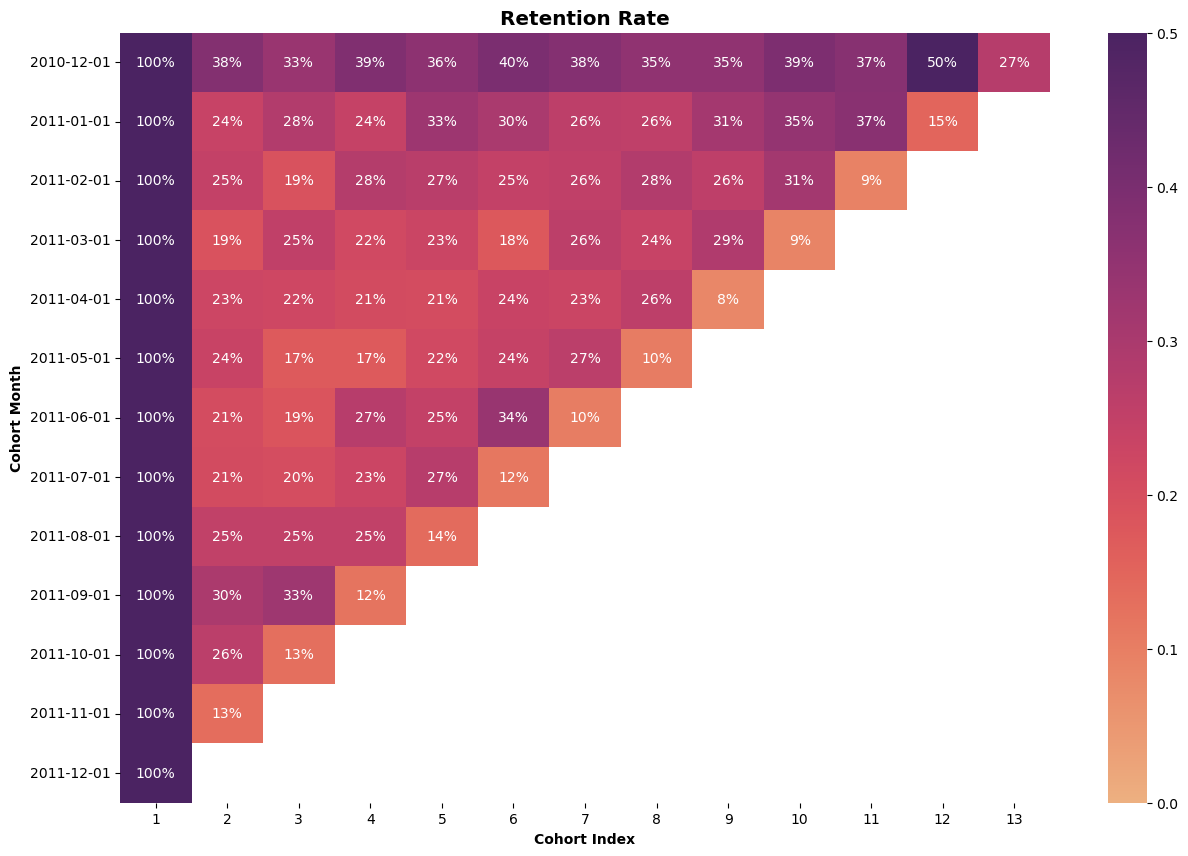

In [14]:
#Retention Rate Heatmap

plt.figure(figsize=(15,10))

ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin= 0.0, vmax=0.5, cmap='flare')

ticklabels = [retention.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]

ax.set_yticklabels(ticklabels)

ax.set_title('Retention Rate', fontsize='x-large', fontweight='heavy')

ax.set_ylabel('Cohort Month', fontweight='bold')
ax.set_xlabel('Cohort Index', fontweight='bold')

plt.show()

**Retention Insights** :

1. First Purchasing Customers in Dec 2010, has a higher overall retention rate throughout the months.
2. Slight increase in customer transactions for returning customers on May 2011. 
3. Nov 2011 is the peak month for returning customers.
4. Aug 2011 can be considered as the lowest customer transaction month for returning customers.
5. The increase momentum of customer transactions return In Sep 2011. 

In [15]:
cohort_mean = month_ind['Quantity'].mean()
cohort_mean = cohort_mean.reset_index()

cohort_avg_quant = cohort_mean.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity').round(1)

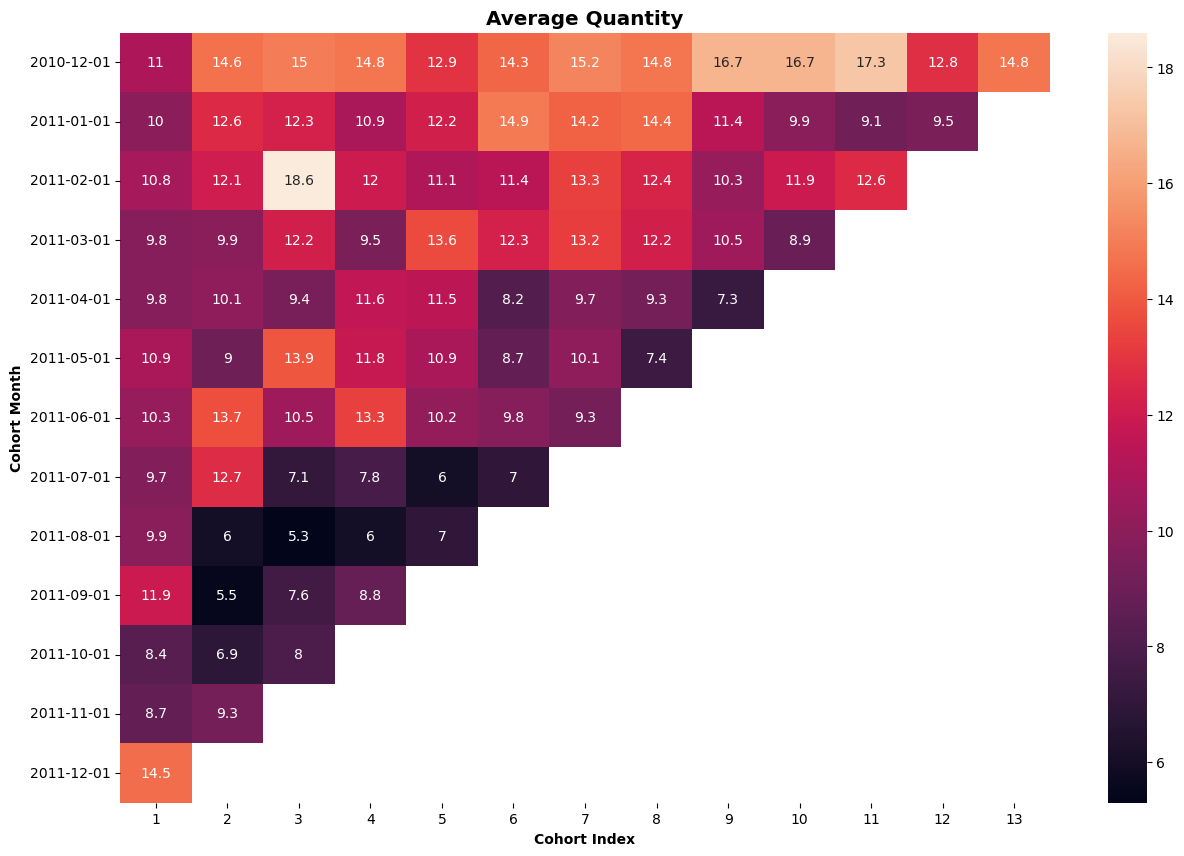

In [16]:
#Cohort Counts

plt.figure(figsize=(15,10))

ax = sns.heatmap(data=cohort_avg_quant, annot=True, cmap='rocket', fmt='g')

ticklabels = [retention.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]

ax.set_yticklabels(ticklabels)

ax.set_title('Average Quantity', fontsize='x-large', fontweight='heavy')

ax.set_ylabel('Cohort Month', fontweight='bold')
ax.set_xlabel('Cohort Index', fontweight='bold')

plt.show()

**Quantity Insights**

1. Customers who started purchasing items in December 2010, purchased much more items on the following months.

2. There is a **slight increase** in the quantity of items purchased on the **month of August**.

3. Previous customers are **purchasing more items** in the **summer months** (June, July, August).

# Recency, Frequency, Monetary Value (RFM)

In [17]:
#Creating A new column of the sum of the transaction of the customer

df['TotalSum'] = df['Quantity'] * df['UnitPrice']

In [18]:
#Finding Out the oldest date and the newset date in the Dataset

print('Oldest Date: ', min(df.InvoiceDate))
print('Most Recent Date: ', max(df.InvoiceDate))

Oldest Date:  2010-12-01 08:26:00
Most Recent Date:  2011-12-09 12:50:00


To calculate the RFM (Recency, Frequency and Monetary Value) Metrics, the timeframe is usually 1 year (12 months). From the Oldest Date and Recent date of the dataset shows that it is exactly 12 months.

Since Current Date is April 2023, I will create a snapshot date to make the recent date closer to the recent date of the dataset.

In [19]:
# Creating new Current Date

from datetime import timedelta

new_current = max(df.InvoiceDate) + dt.timedelta(days=1)

print('Most Recent Date: ', max(df.InvoiceDate))
print('New Recent Date: ', new_current)

Most Recent Date:  2011-12-09 12:50:00
New Recent Date:  2011-12-10 12:50:00


In [20]:
#Creating RFM values

rfm_metric = df.groupby(['CustomerID']).agg({'InvoiceDate' : lambda x: (new_current - x.max()).days, 
                                            'InvoiceNo' : 'count',
                                            'TotalSum' : 'sum'})

rfm_metric.head()

,InvoiceDate,InvoiceNo,TotalSum
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [21]:
#Renaming Column Names

rfm_metric = rfm_metric.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalSum':'MonetaryValue'})

rfm_metric.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


1. **Recency** are the days since the customer's last transaction. (Taken from the New Current Date and the Latest transaction from the customer)

2. **Frequency** is the number of transaction in the past 12 months.

3. **Monetary Value** is how much the customer spent in the past 12 months. 

In [22]:
#Creating Recency score based on quartile

r_labels = range(4, 0, -1)

r_quartiles = pd.qcut(rfm_metric['Recency'], 4, labels=r_labels)

rfm_metric = rfm_metric.assign(R = r_quartiles.values).astype('int64')

rfm_metric

,Recency,Frequency,MonetaryValue,R
CustomerID,,,,
12346.0,326,2,0,1
12347.0,2,182,4310,4
12348.0,75,31,1797,2
12349.0,19,73,1757,3
12350.0,310,17,334,1
...,...,...,...,...
18280.0,278,10,180,1
18281.0,181,7,80,1
18282.0,8,13,176,4


The **larger the recency number**, the **lower the score for R**. This is because the longer the days have passed since their last visit is not a good indicator. 

In [23]:
#Creating Frequency score and Monetary Value Score based on quartile

f_labels = range(1,5)
m_labels = range(1,5)

f_quartiles = pd.qcut(rfm_metric['Frequency'], 4, labels=f_labels)
m_quartiles = pd.qcut(rfm_metric['MonetaryValue'], 4, labels=m_labels)

rfm_metric = rfm_metric.assign(F = f_quartiles.values).astype('int64')
rfm_metric = rfm_metric.assign(M = m_quartiles.values).astype('int64')

rfm_metric

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,2,0,1,1,1
12347.0,2,182,4310,4,4,4
12348.0,75,31,1797,2,2,4
12349.0,19,73,1757,3,3,4
12350.0,310,17,334,1,1,2
...,...,...,...,...,...,...
18280.0,278,10,180,1,1,1
18281.0,181,7,80,1,1,1
18282.0,8,13,176,4,1,1


The **higher the number of Frequency and Monetary Value**, the **higher the score**.

In [24]:
#Creating Column with total of RFM score

def join_rfm(n): return str(n['R']) + str(n['F']) + str(n['M'])

rfm_metric['RFM_Segment'] = rfm_metric.apply(join_rfm, axis=1)
rfm_metric['RFM_Score'] = rfm_metric[['R', 'F', 'M']].sum(axis=1)

rfm_metric

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0,1,1,1,111,3
12347.0,2,182,4310,4,4,4,444,12
12348.0,75,31,1797,2,2,4,224,8
12349.0,19,73,1757,3,3,4,334,10
12350.0,310,17,334,1,1,2,112,4
...,...,...,...,...,...,...,...,...
18280.0,278,10,180,1,1,1,111,3
18281.0,181,7,80,1,1,1,111,3
18282.0,8,13,176,4,1,1,411,6


The purpose of creating RFM Segment is to observe the different types of combination of scores.

In [25]:
#Checking how many types of rfm segements are there in the dataset

rfm_metric['RFM_Segment'].value_counts()

444    471
111    392
122    209
344    206
211    182
      ... 
124      6
142      4
414      3
241      1
441      1
Name: RFM_Segment, Length: 62, dtype: int64

In [26]:
#Summarizing the Metrics by RFM score

by_rfm_score = rfm_metric.groupby('RFM_Score').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue':['mean', 'count']}).round(1)

by_rfm_score

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           264.8       7.8         108.7   392
4           174.4      13.9         226.8   392
5           153.1      21.2         346.4   516
6            94.3      28.5         491.3   468
7            78.8      39.7         723.7   447
8            62.7      57.0         974.2   467
9            44.2      79.0        1369.1   411
10           31.3     115.3        1893.6   440
11           20.5     193.9        3845.2   368
12            6.7     371.8        8850.3   471

In [27]:
#Creating a more general ranking category

rank_category = []

for n in rfm_metric['RFM_Score']:
    if n <= 4 : rank_category.append('Bronze')
    elif n < 9 : rank_category.append('Silver')
    elif n >= 9 : rank_category.append('Gold')

rfm_metric['General_Segment'] = rank_category

rfm_metric['General_Segment'] = rfm_metric['General_Segment'].astype('category')

rfm_metric['General_Segment'] = rfm_metric['General_Segment'].cat.reorder_categories(['Bronze', 'Silver', 'Gold'], ordered=True)

rfm_metric

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12346.0,326,2,0,1,1,1,111,3,Bronze
12347.0,2,182,4310,4,4,4,444,12,Gold
12348.0,75,31,1797,2,2,4,224,8,Silver
12349.0,19,73,1757,3,3,4,334,10,Gold
12350.0,310,17,334,1,1,2,112,4,Bronze
...,...,...,...,...,...,...,...,...,...
18280.0,278,10,180,1,1,1,111,3,Bronze
18281.0,181,7,80,1,1,1,111,3,Bronze
18282.0,8,13,176,4,1,1,411,6,Silver


In [28]:
#Grouping by General Segment

rfm_metric.groupby('General_Segment').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue':['mean', 'count']}).round(1).sort_values('General_Segment', ascending=False)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Gold               25.2     195.1        4129.8  1690
Silver             98.9      36.1         625.5  1898
Bronze            219.6      10.9         167.7   784

1. **Gold Segment** is for customers who scored 9 or Higher.
2. **Silver Segment** is for customers who scored 5 but lower than 9.
3. **Bronze Segment** is for customers who scored 4 or below.

# K-Means Clustering

**Data Preprocessing**

To improve the success of using K-Means, few things need to be considered about the data:

1. The distribution is not skewed
2. Variables with same average values
3. Variables with same variance

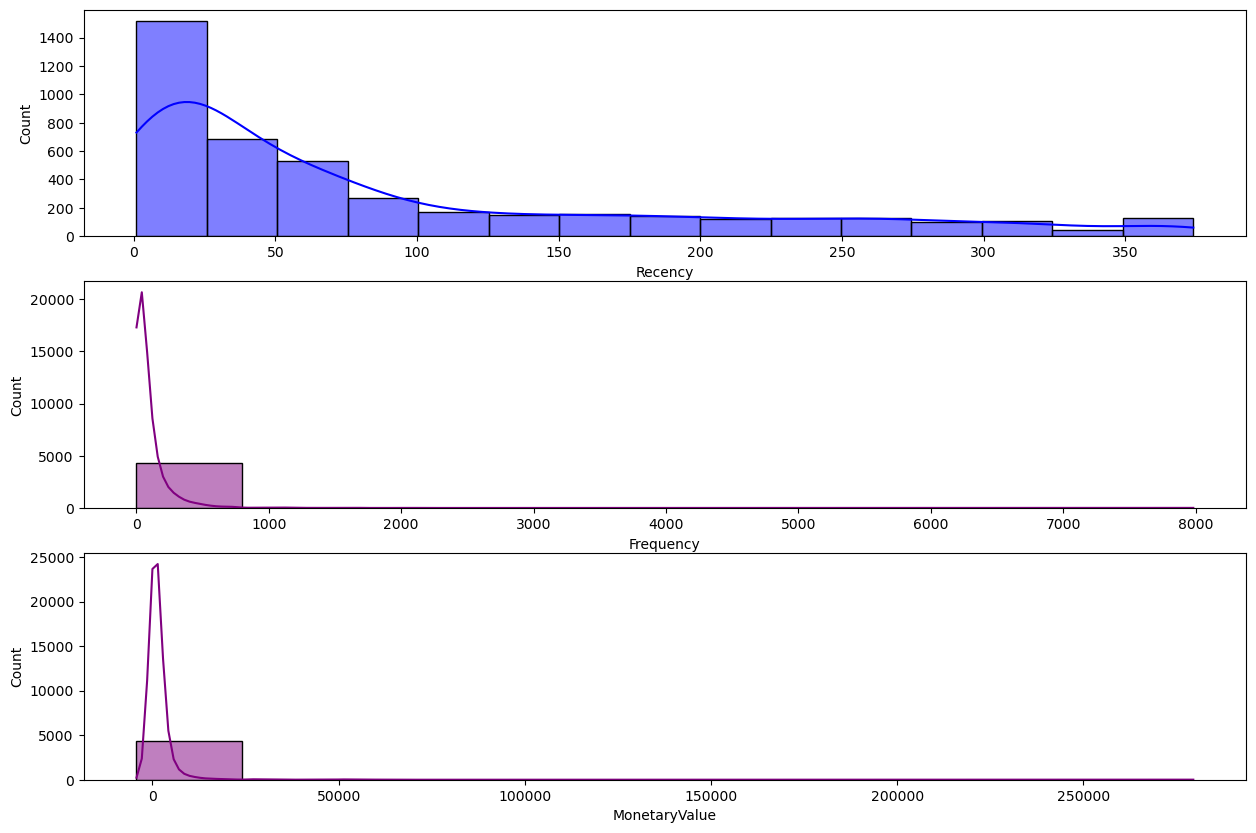

In [29]:
#Checking the distribution of the RFM features

fig, ax = plt.subplots(3, 1, figsize=(15, 10))

sns.histplot(ax=ax[0], data=rfm_metric, x='Recency', bins=15, kde=True, color='blue')
sns.histplot(ax=ax[1], data=rfm_metric, x='Frequency', bins=10, kde=True, color='purple')
sns.histplot(ax=ax[2], data=rfm_metric, x='MonetaryValue', bins=10, kde=True, color='purple')

plt.show()

As we can see, the data is skewed. To fix this we will apply a log tansformation to all of the RFM Metrics to get it closer to a normal distribution. 

In [30]:
rfm_metric_clust = rfm_metric[['Recency', 'Frequency', 'MonetaryValue']]

In [31]:
rfm_metric_clust.query("MonetaryValue == 0")

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0
12454.0,53,30,0
12558.0,2,22,0
12607.0,58,202,0
13256.0,14,1,0
13364.0,67,20,0
13762.0,204,14,0
14557.0,64,32,0
14792.0,64,4,0


In [32]:
rfm_metric_clust['MonetaryValue'] = rfm_metric_clust['MonetaryValue'].replace(0, 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


To solve the problem of having negative infinity or infinity numbers in the log transformation, I decided to replace all values of 0 into 1. 

In [33]:
rfm_metric_clust 

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,1
12347.0,2,182,4310
12348.0,75,31,1797
12349.0,19,73,1757
12350.0,310,17,334
...,...,...,...
18280.0,278,10,180
18281.0,181,7,80
18282.0,8,13,176


In [34]:
rfm_metric_clust_log = np.log(rfm_metric_clust)

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_metric_scaled = scaler.fit_transform(rfm_metric_clust_log)

In [36]:
rfm_metric_scaled = np.nan_to_num(rfm_metric_scaled)

I applied the code above to remove infinite numbers after the values has been scaled. If not, I will not be able to fit the data into Kmeans.

In [37]:
from sklearn.cluster import KMeans

sse = {}

for n in range(1, 13):
    kmeans = KMeans(n_clusters=n, random_state=21)
    kmeans.fit(rfm_metric_scaled)
    sse[n] = kmeans.inertia_

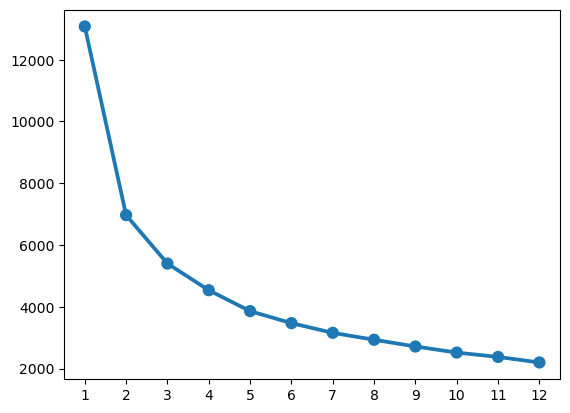

In [38]:
#Using Elbow Method to find the best n value

sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

plt.show()

In [39]:
#Kmeans with 3 Clusters

kmeans = KMeans(n_clusters = 3, random_state = 21)
kmeans.fit(rfm_metric_scaled)
cluster_labels = kmeans.labels_

In [40]:
#Grouping into the 3 Segments

rfm_metric_k3 = rfm_metric.assign(Cluster = cluster_labels)

rfm_metric_k3.groupby(['Cluster']).agg({'Recency': 'mean', 'Frequency':'mean', 'MonetaryValue':['mean', 'count']}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         173.0      15.0         264.0  1532
1          67.0      67.0        1059.0  1857
2          12.0     264.0        6029.0   983

In [41]:
#Kmeans with 4 Clusters

kmeans = KMeans(n_clusters = 4, random_state = 21)
kmeans.fit(rfm_metric_scaled)
cluster_labels = kmeans.labels_

In [42]:
#Grouping into the 4 Segments

rfm_metric_k4 = rfm_metric.assign(Cluster = cluster_labels)

rfm_metric_k4.groupby(['Cluster']).agg({'Recency': 'mean', 'Frequency':'mean', 'MonetaryValue':['mean', 'count']}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          12.0     288.0        6588.0   868
1         185.0      15.0         263.0  1384
2          94.0      81.0        1337.0  1297
3          18.0      38.0         586.0   823

In [43]:
#Kmeans with 5 Clusters

kmeans = KMeans(n_clusters = 5, random_state = 21)
kmeans.fit(rfm_metric_scaled)
cluster_labels = kmeans.labels_

In [44]:
#Grouping into the 5 Segments

rfm_metric_k5 = rfm_metric.assign(Cluster = cluster_labels)

rfm_metric_k5.groupby(['Cluster']).agg({'Recency': 'mean', 'Frequency':'mean', 'MonetaryValue':['mean', 'count']}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          16.0      42.0         636.0   774
1         165.0      31.0         502.0  1221
2          60.0     119.0        1932.0   999
3           8.0     326.0        7908.0   650
4         169.0       7.0         167.0   728

In [45]:
#Transforming scaled data to a DataFrame & Adding Column

rfm_metric_scaled = pd.DataFrame(rfm_metric_scaled, index=rfm_metric_clust.index, columns=rfm_metric_clust.columns)

rfm_metric_scaled['3_Cluster'] = rfm_metric_k3['Cluster'] 
rfm_metric_scaled['4_Cluster'] = rfm_metric_k4['Cluster'] 
rfm_metric_scaled['5_Cluster'] = rfm_metric_k5['Cluster']

rfm_metric_scaled

,Recency,Frequency,MonetaryValue,3_Cluster,4_Cluster,5_Cluster
CustomerID,,,,,,
12346.0,1.402917,-2.230272,-5.030353,0,1,4
12347.0,-2.075135,1.133419,1.399522,2,0,3
12348.0,0.399593,-0.186462,0.727377,1,2,2
12349.0,-0.537936,0.452198,0.710081,1,2,2
12350.0,1.368554,-0.634452,-0.565509,0,1,1
...,...,...,...,...,...,...
18280.0,1.294161,-1.030135,-1.040475,0,1,4
18281.0,1.001152,-1.296103,-1.663533,0,1,4
18282.0,-1.128562,-0.834493,-1.057741,0,3,0


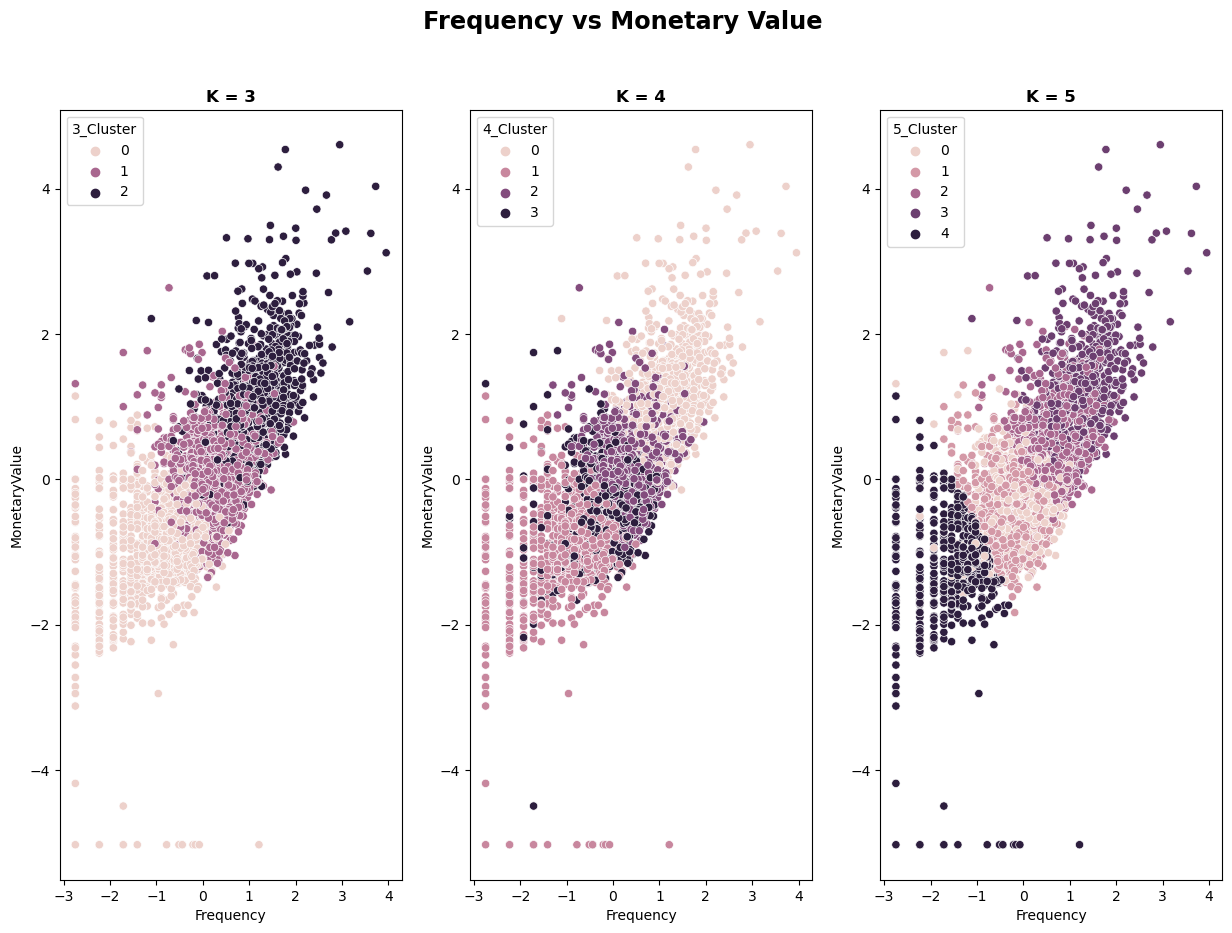

In [46]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

fig.suptitle('Frequency vs Monetary Value', fontweight='heavy', size='xx-large')

sns.scatterplot(ax=ax[0], x='Frequency', y='MonetaryValue', hue='3_Cluster', data=rfm_metric_scaled )
sns.scatterplot(ax=ax[1], x='Frequency', y='MonetaryValue', hue='4_Cluster', data=rfm_metric_scaled )
sns.scatterplot(ax=ax[2], x='Frequency', y='MonetaryValue', hue='5_Cluster', data=rfm_metric_scaled )

ax[0].set_title('K = 3',fontweight='bold')
ax[1].set_title('K = 4',fontweight='bold')
ax[2].set_title('K = 5',fontweight='bold')

plt.show()

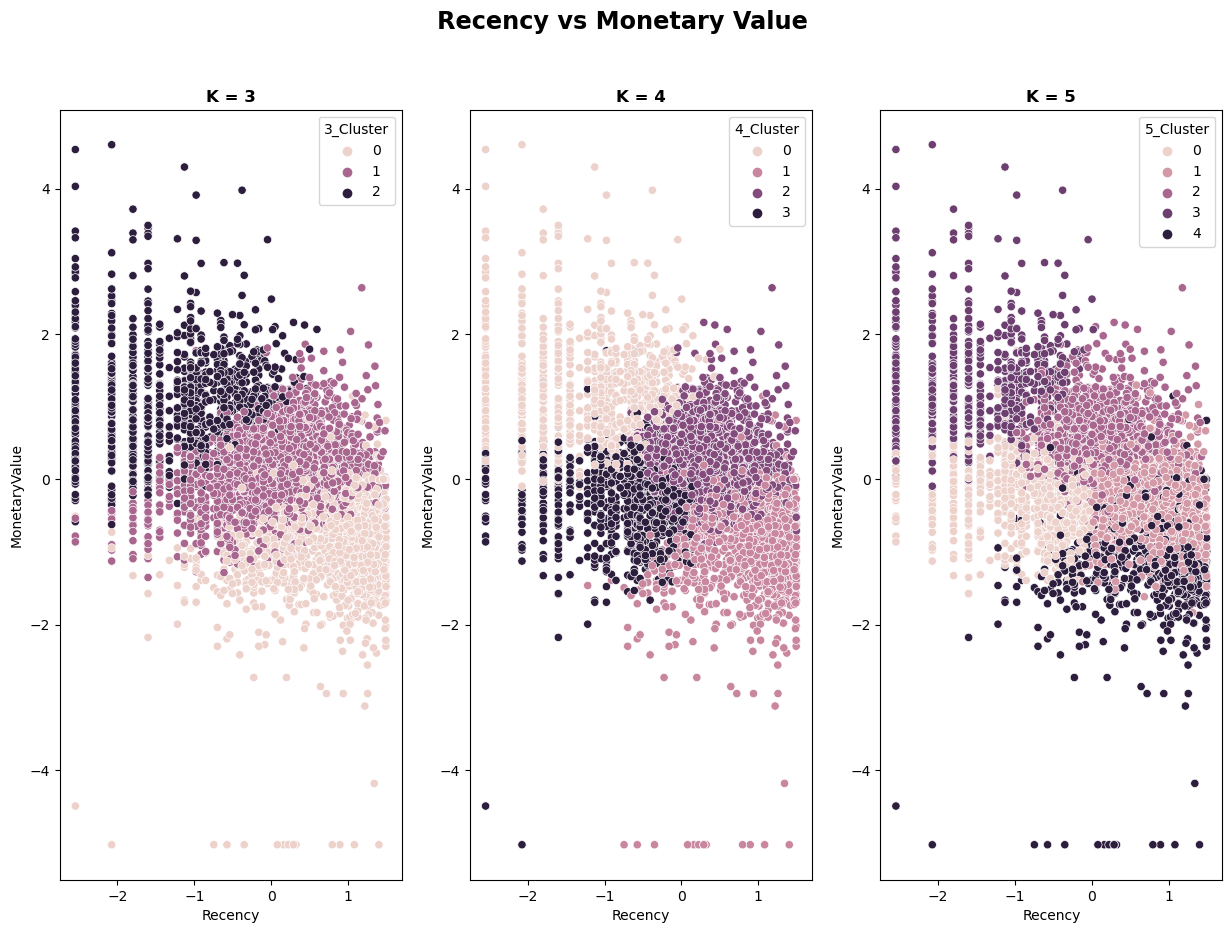

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

fig.suptitle('Recency vs Monetary Value', fontweight='heavy', size='xx-large')

sns.scatterplot(ax=ax[0], x='Recency', y='MonetaryValue', hue='3_Cluster', data=rfm_metric_scaled )
sns.scatterplot(ax=ax[1], x='Recency', y='MonetaryValue', hue='4_Cluster', data=rfm_metric_scaled )
sns.scatterplot(ax=ax[2], x='Recency', y='MonetaryValue', hue='5_Cluster', data=rfm_metric_scaled )

ax[0].set_title('K = 3',fontweight='bold')
ax[1].set_title('K = 4',fontweight='bold')
ax[2].set_title('K = 5',fontweight='bold')

plt.show()

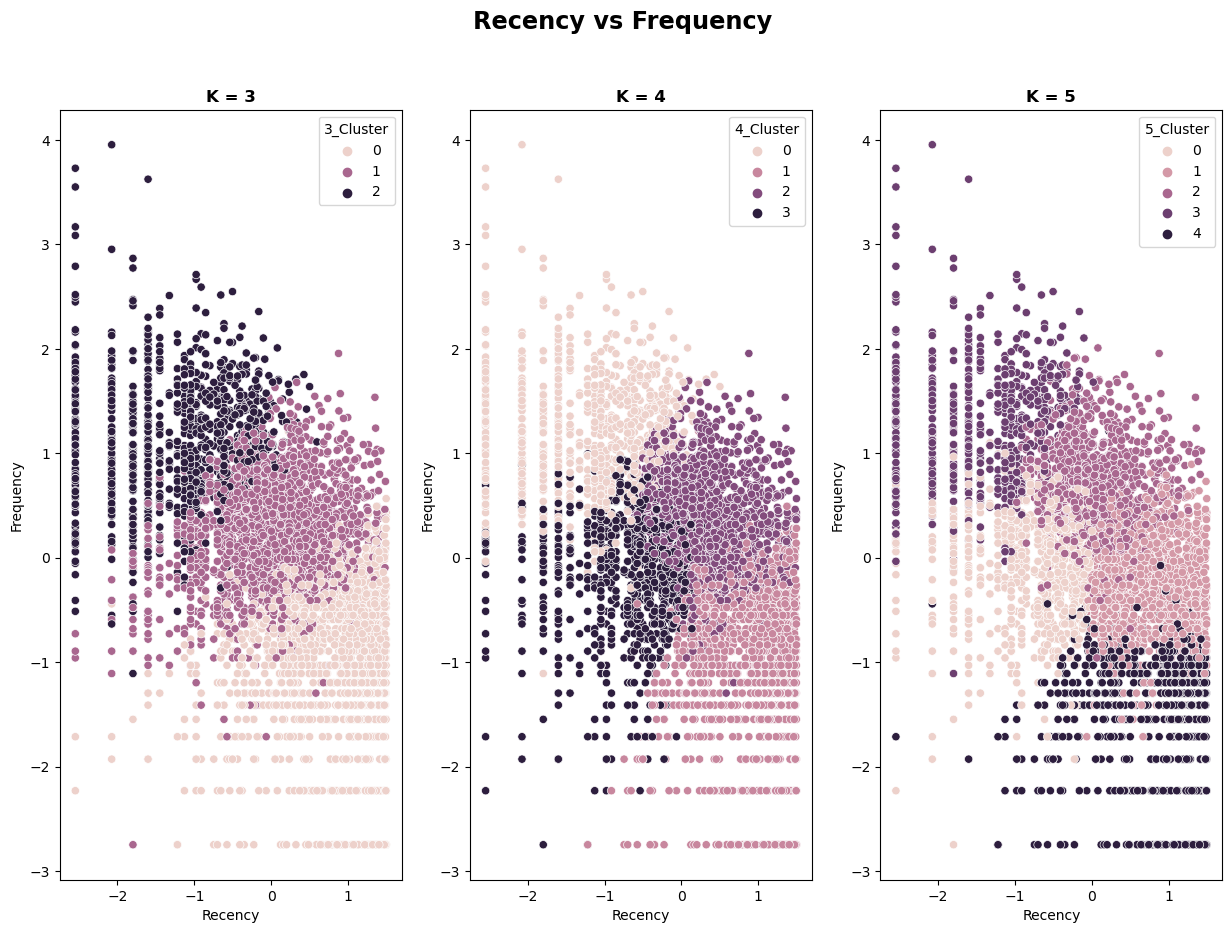

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

fig.suptitle('Recency vs Frequency', fontweight='heavy', size='xx-large')

sns.scatterplot(ax=ax[0], x='Recency', y='Frequency', hue='3_Cluster', data=rfm_metric_scaled )
sns.scatterplot(ax=ax[1], x='Recency', y='Frequency', hue='4_Cluster', data=rfm_metric_scaled )
sns.scatterplot(ax=ax[2], x='Recency', y='Frequency', hue='5_Cluster', data=rfm_metric_scaled )

ax[0].set_title('K = 3',fontweight='bold')
ax[1].set_title('K = 4',fontweight='bold')
ax[2].set_title('K = 5',fontweight='bold')

plt.show()

After observing the plot, in my opinion customer segmentation is best when segmented into **3 customer segmentation**.

In [49]:
rfm_metric_k3.groupby(['Cluster']).agg({'Recency': 'mean', 'Frequency':'mean', 'MonetaryValue':['mean', 'count']}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         173.0      15.0         264.0  1532
1          67.0      67.0        1059.0  1857
2          12.0     264.0        6029.0   983

# Conclusion

**Assumptions about the type of customers**:

1. Cluster 0 : For customers who rarely visit and rarely purchase items. Probably customers who are fairly new to the store and just purchase items that they need. 

2. Cluster 1 : Customers who are knowledgeable in what the store offers and purchase items only if they find the items interesting.  

3. Cluster 2 : Customers who are considered as subscribers in shopping on the online retail store. Their daily needs are bought in this online retail store. 


My recommendation is to increase the spending habits of the customers in cluster 1 due to few reasons:

1. Large amount of customers in that segment.
2. Visits the shop frequently but does not spend a lot of money in the store.

Ways to increase their spending habits:

1. Giving out more promos and sales for items.
2. Giving out membership benefits for frequent buyers. The more you buy, the more you get.
3. Reduce delivery costs for frequent customers